RSI
- 과매수(탐욕)나 과매도(공포)를 판단하는데 사용하는 지표
- 0~ 100사이의 값을 가짐
  - 70 이상은 과매수 상태
  - 30 이하는 과매도 상태

In [1]:
!pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.2/254.2 kB 11.8 MB/s eta 0:00:00


In [2]:
from pykrx import stock

df = stock.get_market_ohlcv_by_date("20140101", '20241121', '145720')[['종가']]
df.head()

,종가
날짜,
2017-03-15,34500
2017-03-16,35500
2017-03-17,37100
2017-03-20,36100
2017-03-21,35850


In [3]:
import numpy as np
df['변화량'] = df['종가'] - df['종가'].shift(1)
df['상승폭'] = np.where(df['변화량'] >= 0,  df['변화량'], 0)
df['하락폭'] = np.where(df['변화량'] < 0,  abs(df['변화량']), 0)
df.head()

,종가,변화량,상승폭,하락폭
날짜,,,,
2017-03-15,34500,NaN,0.0,0.0
2017-03-16,35500,1000.0,1000.0,0.0
2017-03-17,37100,1600.0,1600.0,0.0
2017-03-20,36100,-1000.0,0.0,1000.0
2017-03-21,35850,-250.0,0.0,250.0


<Axes: xlabel='날짜'>

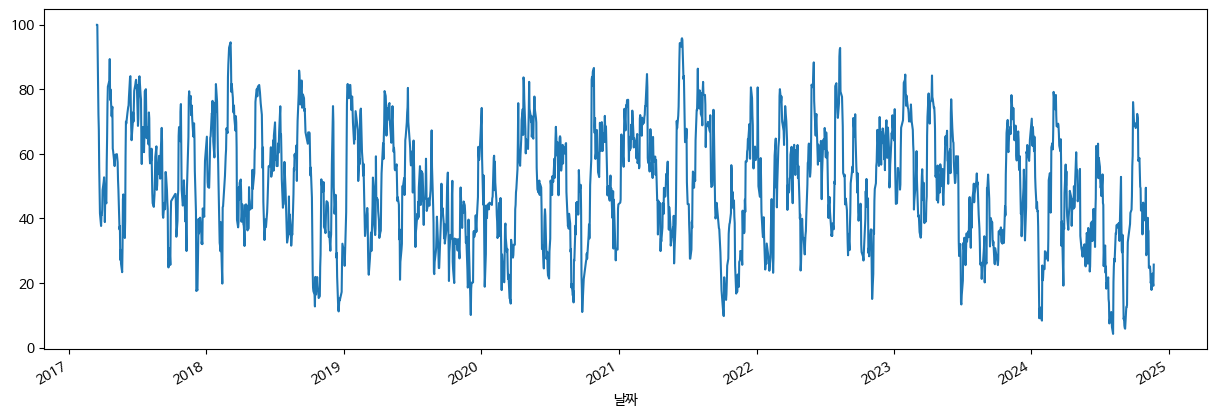

In [8]:
df['평균상승폭'] = df['상승폭'].rolling(window=14, min_periods=1).mean()
df['평균하락폭'] = df['하락폭'].rolling(window=14, min_periods=1).mean()
df['RSI'] = df['평균상승폭'] / (df['평균상승폭'] + df['평균하락폭']) * 100
df['RSI'].plot(figsize = (15,5))

### 벡테스팅

In [11]:
df['일간수익률'] = df['종가'].pct_change()
df.head()

,종가,변화량,상승폭,하락폭,평균상승폭,평균하락폭,RSI,일간수익률
날짜,,,,,,,,
2017-03-15,34500,NaN,0.0,0.0,0.000000,0.0,NaN,NaN
2017-03-16,35500,1000.0,1000.0,0.0,500.000000,0.0,100.000000,0.028986
2017-03-17,37100,1600.0,1600.0,0.0,866.666667,0.0,100.000000,0.045070
2017-03-20,36100,-1000.0,0.0,1000.0,650.000000,250.0,72.222222,-0.026954
2017-03-21,35850,-250.0,0.0,250.0,520.000000,250.0,67.532468,-0.006925


In [13]:
# RSI 매매 매수 신호 판단
df.loc[df['RSI'] < 30, '매수신호'] = True
df.loc[df['RSI'] > 70, '매수신호'] = False # 매도 신호

In [18]:
df.loc[df['매수신호'].shift(1) == True, '보유여부'] = True # 전날 매수 신호O -> 보유
df.loc[df['매수신호'].shift(1) == False, '보유여부'] = False # 전날 매수신호X -> 미보유
df['보유여부'].ffill(inplace=True) # 조건이 없으면 전날 상태 유지
df['보유여부'].fillna(False, inplace = True)

In [22]:
df['보유수익률'] = np.where(df['보유여부']==True, df['일간수익률'], 0)
df.head()

,종가,변화량,상승폭,하락폭,평균상승폭,평균하락폭,RSI,일간수익률,매수신호,보유여부,보유수익률
날짜,,,,,,,,,,,
2017-03-15,34500,NaN,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,False,0.0
2017-03-16,35500,1000.0,1000.0,0.0,500.000000,0.0,100.000000,0.028986,False,False,0.0
2017-03-17,37100,1600.0,1600.0,0.0,866.666667,0.0,100.000000,0.045070,False,False,0.0
2017-03-20,36100,-1000.0,0.0,1000.0,650.000000,250.0,72.222222,-0.026954,False,False,0.0
2017-03-21,35850,-250.0,0.0,250.0,520.000000,250.0,67.532468,-0.006925,NaN,False,0.0


In [28]:
RSI_누적수익률 = ((df['보유수익률'] + 1).cumprod() - 1).iloc[-1]
단순보유_누적수익률 = ((df['일간수익률'] + 1).cumprod() - 1).iloc[-1]
print(RSI_누적수익률, 단순보유_누적수익률)

-0.05203044978564286 0.6550724637681105


<Axes: xlabel='날짜'>

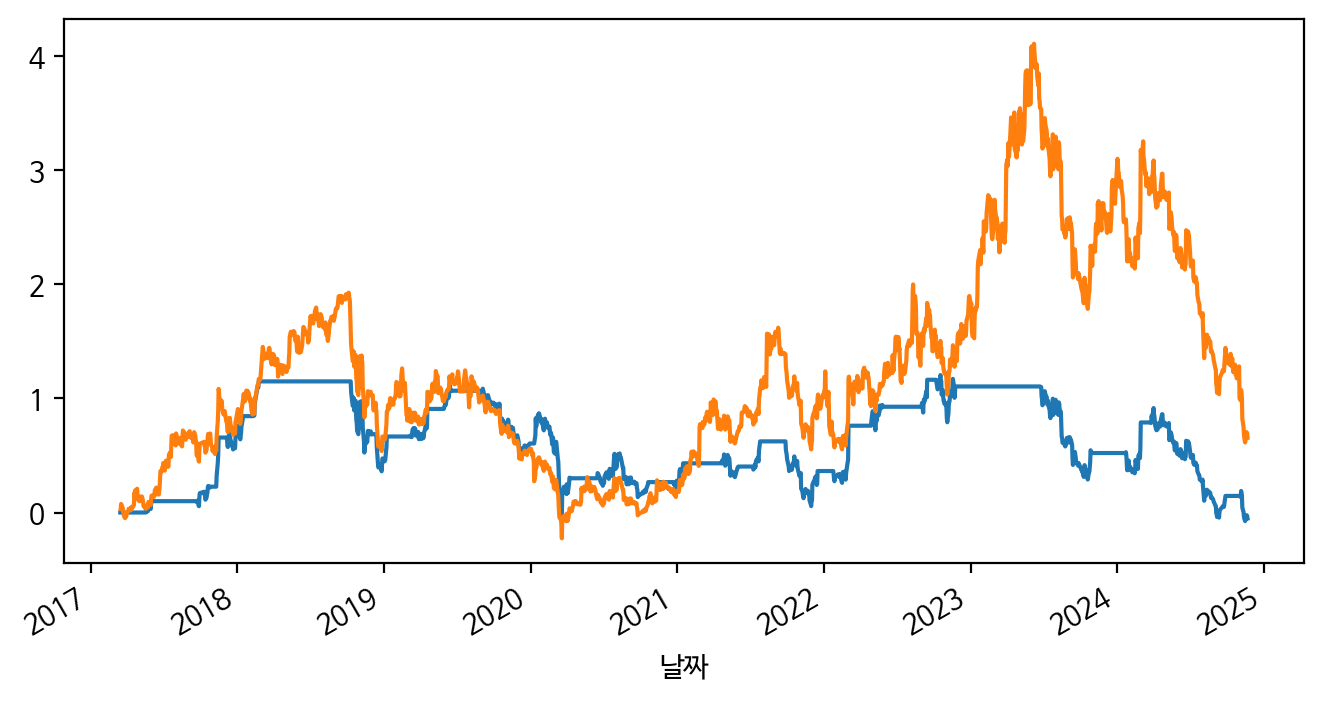

In [33]:
import matplotlib.pyplot as plt
import platform
plt.rcParams['figure.dpi'] = 200

((df['보유수익률'] + 1).cumprod() - 1).plot(figsize=(8, 4))
((df['일간수익률'] + 1).cumprod() - 1).plot(figsize=(8, 4))